## Essencial Functions and Libraries

In [9]:
import torch
import os
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
import torch.optim as optim
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from itertools import product
import concurrent.futures
from sklearn.metrics import average_precision_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
import optuna
from scipy.special import expit
from sklearn.metrics import f1_score

NUM_CLASSES = 3  
SPLIT_TRAIN_TEST = 0.8  # 80% train, 20% test  
SPLIT_TRAIN_VAL = 0.2 # 80% train, 20% validation
BATCH_SIZE = 8  # Batch size for DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BeetsSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
       
        self.mean = np.mean(images, axis=(0, 1, 2))
        self.std = np.std(images, axis=(0, 1, 2))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # (H, W, C)
        mask = self.masks[idx]  # (H, W)

        img = (img - self.mean) / (self.std + 1e-8)

        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        if not torch.is_tensor(mask):
            mask = torch.from_numpy(mask)

        return img_tensor, mask

def get_deeplabv3_model(num_classes):
    model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
    # Get the original conv1 layer
    orig_conv = model.backbone.conv1
    new_conv = torch.nn.Conv2d(
        in_channels=4,
        out_channels=orig_conv.out_channels,
        kernel_size=orig_conv.kernel_size,
        stride=orig_conv.stride,
        padding=orig_conv.padding,
        bias=orig_conv.bias is not None
    )
    with torch.no_grad():
        new_conv.weight[:, :3] = orig_conv.weight  # Copy RGB weights
        new_conv.weight[:, 3] = orig_conv.weight[:, 0]  # Initialize 4th channel
        model.backbone.conv1 = new_conv
        # Update classifier for your number of classes
        model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
        return model

/home/wilgo/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Dataset

### Read data

In [ ]:
dataset_dir = 'spotlite_dataset_loca1_date1_dir1'

images_dataset_dir = os.path.join(dataset_dir, 'images')
masks_dataset_dir = os.path.join(dataset_dir, 'masks')

# Verify if directories exist (optional, but recommended)
assert os.path.exists(images_dataset_dir), f"Images directory not found: {images_dataset_dir}"
assert os.path.exists(masks_dataset_dir), f"Masks directory not found: {masks_dataset_dir}"

image_files = sorted(os.listdir(images_dataset_dir))
mask_files = sorted(os.listdir(masks_dataset_dir))

imgs, masks = [], []

# Check if the number of files match
assert len(image_files) == len(mask_files), "Number of images and masks don't match."

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(images_dataset_dir, image_file)
    mask_path = os.path.join(masks_dataset_dir, mask_file)

    read_img = tiff.imread(image_path)
    read_mask = tiff.imread(mask_path)

    imgs.append(read_img)
    masks.append(read_mask)

imgs = np.stack(imgs)   # (N, H, W, C)
masks = np.stack(masks) # (N, H, W)

print(f'shape of imgs: {imgs.shape}')
print(f'shape of masks: {masks.shape}')

### Convert labels in masks

In [ ]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped.long()

masks = remap_mask(masks)

### Obtain Dataloaders

In [ ]:
full_dataset = BeetsSegmentationDataset(imgs, masks)

train_size = int(SPLIT_TRAIN_TEST * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset_raw, test_dataset = random_split(full_dataset, [train_size, test_size])

val_size = int(SPLIT_TRAIN_VAL * len(train_dataset_raw))
real_train_size = len(train_dataset_raw) - val_size
train_dataset, val_dataset = random_split(train_dataset_raw, [real_train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for imgs_i, masks_i in train_loader:
    print("Train Images:", imgs_i.shape)
    break

for imgs_i, masks_i in val_loader:
    print("Val Images:", imgs_i.shape)
    break

### Save Dataloaders

In [ ]:
def save_dataloaders(train_loader, val_loader, test_loader, filename='dataloaders.pth'):
    dataloaders = {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }
    torch.save(dataloaders, filename)
    print(f"Dataloaders saved to {filename}")

save_dataloaders(train_loader, val_loader, test_loader)

## Train model

### Load model and dataloaders

In [ ]:
model = get_deeplabv3_model(NUM_CLASSES)

dataloaders = torch.load('dataloaders.pth')
train_loader = dataloaders['train_loader']
val_loader = dataloaders['val_loader']

### Train DeepLabV3 model

In [ ]:
def train_deeplabv3(model, train_loader, val_loader, num_epochs=100, lr=1e-4, device='cuda', patience=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # -------------------
        # Training
        # -------------------
        model.train()
        running_train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            progress_bar.set_postfix({"train_loss": f"{loss.item():.4f}"})

        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # -------------------
        # Validation
        # -------------------
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device).long()

                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                running_val_loss += loss.item() * images.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # -------------------
        # Early stopping
        # -------------------
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # -------------------
    # Salve the best model
    # -------------------
    if best_model_state is not None:
        torch.save(best_model_state, 'best_deeplabv3_model.pth')
        print("Best model saved with validation loss:", best_val_loss)

    print("Training complete.")

train_deeplabv3(model, train_loader, val_loader, num_epochs=100, lr=1e-4, device=DEVICE, patience=10)

## Test model

### Load  model and dataloaders

In [4]:
model = get_deeplabv3_model(NUM_CLASSES)
model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
model = model.to(DEVICE)
model.eval()

dataloaders = torch.load('dataloaders.pth')
test_loader = dataloaders['test_loader']

/tmp/ipykernel_394127/1401991351.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
/tmp/ipykernel_394127/1401

### Calculate Metrics

0-Background - Average Precision: 0.9908
1-Pinus - Average Precision: 0.0808
2-Eucalyptus - Average Precision: 0.7450

Mean Average Precision (mAP): 0.6055


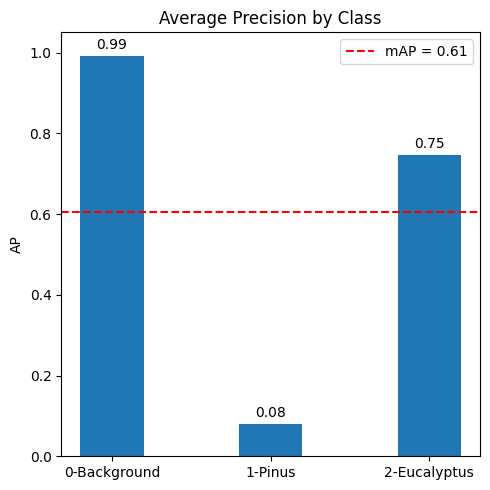

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
import torch

class_names = ['0-Background', '1-Pinus', '2-Eucalyptus']

def compute_average_precision_per_class(model, dataloader, num_classes, device='cuda'):
    model.eval()
    all_labels = [[] for _ in range(num_classes)]
    all_probs = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).long()
            outputs = model(images)['out']
            probs = torch.softmax(outputs, dim=1).cpu()
            masks = masks.cpu()

            for c in range(num_classes):
                true_c = (masks == c).float().reshape(-1).numpy()
                prob_c = probs[:, c, :, :].reshape(-1).numpy()
                all_labels[c].extend(true_c)
                all_probs[c].extend(prob_c)

    ap_per_class = []
    for c in range(num_classes):
        if len(np.unique(all_labels[c])) < 2:
            ap = float('nan') 
        else:
            ap = average_precision_score(all_labels[c], all_probs[c])
        ap_per_class.append(ap)

    mean_ap = np.nanmean(ap_per_class)
    return ap_per_class, mean_ap

ap_per_class, mean_ap = compute_average_precision_per_class(model, test_loader, num_classes=3, device='cuda')

for name, ap in zip(class_names, ap_per_class):
    print(f"{name} - Average Precision: {ap:.4f}")
print(f"\nMean Average Precision (mAP): {mean_ap:.4f}")

plt.figure(figsize=(5, 5))
bars = plt.bar(class_names, ap_per_class, width=0.4)

for bar, ap in zip(bars, ap_per_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{ap:.2f}', ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.axhline(mean_ap, color='red', linestyle='--', label=f'mAP = {mean_ap:.2f}')
plt.title('Average Precision by Class')
plt.ylabel('AP')
plt.legend()
plt.tight_layout()
plt.show()

## Imprecise Probability

### Obtain likelihoods

In [10]:
model = get_deeplabv3_model(NUM_CLASSES)
model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
model = model.to(DEVICE)
model.eval()

dataloaders = torch.load('dataloaders.pth')
train_loader = dataloaders['train_loader']
val_loader = dataloaders['val_loader']
test_loader = dataloaders['test_loader']

def get_likelihoods(model, loader):
    all_likelihoods = []
    all_masks = []
    with torch.no_grad():
        for images, mask in loader:
            images = images.to(DEVICE)
            mask = mask.to(DEVICE).long()
            outputs = model(images)['out']
            likelihoods = torch.softmax(outputs, dim=1).cpu()
            all_likelihoods.append(likelihoods)
            all_masks.append(mask.cpu())
    
    return torch.cat(all_likelihoods, dim=0), torch.cat(all_masks, dim=0)

train_likelihoods, train_labels = get_likelihoods(model, train_loader)
val_likelihoods, val_labels = get_likelihoods(model, val_loader)
test_likelihoods, test_labels = get_likelihoods(model, test_loader)

print(f"Train likelihoods and masks shape: {train_likelihoods.shape} | {train_labels.shape}")
print(f"Validation likelihoods and masks shape: {val_likelihoods.shape} | {val_labels.shape}")
print(f"Test likelihoods and masks shape: {test_likelihoods.shape} | {test_labels.shape}")

/tmp/ipykernel_75296/1508212436.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
/tmp/ipykernel_75296/150821

Train likelihoods and masks shape: torch.Size([122, 3, 512, 512]) | torch.Size([122, 512, 512])
Validation likelihoods and masks shape: torch.Size([30, 3, 512, 512]) | torch.Size([30, 512, 512])
Test likelihoods and masks shape: torch.Size([39, 3, 512, 512]) | torch.Size([39, 512, 512])


### Framework

#### Metrics

In [11]:
class Metrics:

    def flatten_probs_labels(probs, labels):
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
        labels_flat = labels.view(-1)  # (N*H*W,)
        return probs_flat, labels_flat

    def compute_average_precision(probs, labels, num_classes=3):
        probs_flat, labels_flat = Metrics.flatten_probs_labels(probs, labels)
        AP_per_class = []

        for c in range(num_classes):
            # True binary labels for class c (1 if pixel == c, 0 otherwise)
            true_binary = (labels_flat == c).cpu().numpy()
            # Probabilities for class c
            prob_c = probs_flat[:, c].cpu().numpy()

            if np.sum(true_binary) == 0:
                AP_per_class.append(np.nan)  # No positive samples, skip
            else:
                AP = average_precision_score(true_binary, prob_c)
                AP_per_class.append(AP)

        # Mean AP (mAP), ignoring NaNs
        mAP = np.nanmean(AP_per_class)
        return AP_per_class, mAP

    def compute_ece(probs, labels, num_bins=10):
        # Convert to numpy
        probs_flat, labels_flat = Metrics.flatten_probs_labels(probs, labels)
        confidences, predictions = torch.max(probs_flat, dim=1)
        confidences = confidences.cpu().numpy()
        predictions = predictions.cpu().numpy()
        labels_flat = labels_flat.cpu().numpy()

        bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
        ece = 0.0

        for i in range(num_bins):
            bin_lower = bin_boundaries[i]
            bin_upper = bin_boundaries[i + 1]

            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = np.mean(in_bin)

            if prop_in_bin > 0:
                accuracy_in_bin = np.mean(predictions[in_bin] == labels_flat[in_bin])
                avg_confidence_in_bin = np.mean(confidences[in_bin])
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

    def calculate_coverage(probs, thresholds):
        # Create confident mask: True if prob > threshold for each class
        confident_mask = torch.zeros_like(probs, dtype=torch.bool)
        for c in range(probs.shape[1]):
            confident_mask[:, c, :, :] = probs[:, c, :, :] > thresholds[c]
        # A pixel is certain if at least one class is confident
        certain_pixels = confident_mask.max(dim=1).values  # (N, H, W)
        coverage = float(certain_pixels.sum().item()) / certain_pixels.numel()
        return coverage
    
    def print_metrics(probs, labels, thresholds, name=None):
        APs, mAP = Metrics.compute_average_precision(probs, labels)
        ece = Metrics.compute_ece(probs, labels)
        coverage = Metrics.calculate_coverage(probs, thresholds)

        print(f"\n=== {name} ===")
        print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in APs])
        print("Mean Average Precision (mAP):", f"{mAP:.4f}")
        print("Expected Calibration Error (ECE):", f"{ece:.4f}")
        print("Coverage (proportion of certain pixels):", f"{coverage:.4f}")

    def plot_segmentation_comparison_with_uncertainty(images, masks, preds_baseline, preds_imprecise, image_idx=0, ignore_class=255):
        img = images[image_idx][:3].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())

        gt = masks[image_idx].cpu().numpy()
        base = preds_baseline[image_idx].cpu().numpy()
        cons = preds_imprecise[image_idx].cpu().numpy()

        cons_vis = cons.copy()
        cons_vis[cons_vis == ignore_class] = -1  
        
        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(24, 5))
        axs[0].imshow(img)
        axs[0].set_title("Original Image")
        axs[1].imshow(gt, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(base, cmap='gray')
        axs[2].set_title("Baseline Prediction")
        axs[3].imshow(cons_vis, cmap='gray')
        axs[3].set_title("Prediction with Imprecise Probabilities")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def compute_metrics_certain_pixels(probs, labels, confident_mask, num_classes=3):
        # A pixel is certain if at least one class is confident
        certain_pixels = confident_mask.max(dim=1).values.bool()  # (N, H, W)
        
        # Flatten everything
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)
        labels_flat = labels.view(-1)
        certain_flat = certain_pixels.view(-1)
        
        # Filter only certain pixels
        probs_certain = probs_flat[certain_flat]
        labels_certain = labels_flat[certain_flat]
        
        # Coverage: proportion of certain pixels
        coverage = float(certain_flat.sum().item()) / certain_flat.numel()
        
        # If no certain pixels, return NaN
        if probs_certain.shape[0] == 0:
            return [float('nan')] * num_classes, float('nan'), float('nan'), 0.0
        
        # Average Precision
        AP_per_class = []
        for c in range(num_classes):
            true_binary = (labels_certain == c).cpu().numpy()
            prob_c = probs_certain[:, c].cpu().numpy()
            if np.sum(true_binary) == 0:
                AP_per_class.append(np.nan)
            else:
                AP = average_precision_score(true_binary, prob_c)
                AP_per_class.append(AP)
        mAP = np.nanmean(AP_per_class)
        
        # ECE
        confidences = probs_certain.max(dim=1).values.cpu().numpy()
        predictions = probs_certain.argmax(dim=1).cpu().numpy()
        labels_certain_np = labels_certain.cpu().numpy()
        num_bins = 10
        bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
        ece = 0.0
        for i in range(num_bins):
            bin_lower = bin_boundaries[i]
            bin_upper = bin_boundaries[i + 1]
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = np.mean(in_bin)
            if prop_in_bin > 0:
                accuracy_in_bin = np.mean(predictions[in_bin] == labels_certain_np[in_bin])
                avg_confidence_in_bin = np.mean(confidences[in_bin])
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        print(f"\n=== Imprecise Probability Approach Metrics for Certain Pixels ===")
        print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in AP_per_class])
        print("Mean Average Precision (mAP):", f"{mAP:.4f}")
        print("Expected Calibration Error (ECE):", f"{ece:.4f}")
        print("Coverage (proportion of certain pixels):", f"{coverage:.4f}")

#### Imprecise Probability

In [12]:
class ImpreciseProbsframe:

    def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):
        entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)  # (N, H, W)
        lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       # (N, C, H, W)
        return lower_bound

    def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
        N, C, H, W = lower_bound.shape
        plt.figure(figsize=(8, 4))

        for c in range(C):
            mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
            lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

            if lower_c.numel() > sample_size:
                indices = torch.randperm(lower_c.numel())[:sample_size]
                lower_c = lower_c[indices]

            sns.kdeplot(lower_c.cpu().numpy(), label=f'Classe {c}', linewidth=2)

        plt.title("Distribution of Lower Bounds by Class")
        plt.xlabel("Lower Bound")
        plt.ylabel("Estimated Density")
        plt.legend()
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.grid(True)
        plt.show()

    def obtain_confident_values(lower_bound, thresholds):
        num_classes = lower_bound.shape[1]
        confident_mask = torch.zeros_like(lower_bound, dtype=torch.bool)

        for c in range(num_classes):
            confident_mask[:, c, :, :] = lower_bound[:, c, :, :] > thresholds[c]

        confident_probs = confident_mask.float() * lower_bound

        confident_preds = confident_probs.argmax(dim=1)
        is_uncertain = confident_mask.max(dim=1).values == 0
        confident_preds[is_uncertain] = 255  # 255 for uncertain pixels

        return confident_preds, confident_probs, confident_mask
    
    def fill_uncertain_probs_with_baseline(confident_values, confident_mask, baseline_probs):
        # Create a mask of uncertain pixels (1 if all classes are uncertain)
        uncertain_mask = confident_mask.max(dim=1).values == 0  # (N, H, W)

        # Start with confident_values, but baseline_probs will overwrite uncertain pixels
        final_probs = confident_values.clone()

        # For uncertain pixels, fill with baseline_probs
        for c in range(final_probs.shape[1]):
            final_probs[:, c, :, :][uncertain_mask] = baseline_probs[:, c, :, :][uncertain_mask]

        # Final predictions (argmax)
        pred_filled = final_probs.argmax(dim=1)
        return final_probs, pred_filled

#### Quartile Approach

In [13]:
class QuartileApproach:

    def thresholds_from_lower_percentile(lower_bound, labels, quartile, max_samples=100_000):
        N, C, H, W = lower_bound.shape

        thresholds = []
        for c in range(C):
            mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
            lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

            if lower_c.numel() == 0:
                thresholds.append(0.5)  # fallback
            else:
                if lower_c.numel() > max_samples:
                    indices = torch.randperm(lower_c.numel())[:max_samples]
                    lower_c = lower_c[indices]
                
                    if f'class{c}' in quartile:
                        q = quartile[f'class{c}']
                        
                threshold = torch.quantile(lower_c, q).item()
                thresholds.append(threshold)
        return thresholds

    def optimize_quartiles(cal_lower_bound, cal_gt_masks, cal_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75], num_classes=3):
        N = cal_lower_bound.shape[0]
        indices = np.arange(N)
        np.random.shuffle(indices)
        fold_size = N // num_folds

        best_quartiles = {}
        best_score = -float('inf')

        quartile_combinations = list(product(quartile_range, repeat=num_classes))

        def evaluate_quartile_combo(combo):
            quartile = {f'class{c}': combo[c] for c in range(num_classes)}
            scores = []
            for fold in range(num_folds):
                val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
                train_indices = np.setdiff1d(indices, val_indices)

                train_lower_bound = cal_lower_bound[train_indices]
                train_gt_masks = cal_gt_masks[train_indices]
                thresholds = QuartileApproach.thresholds_from_lower_percentile(train_lower_bound, train_gt_masks, quartile)

                val_lower_bound = cal_lower_bound[val_indices]
                val_gt_masks = cal_gt_masks[val_indices]
                val_probs = cal_probs[val_indices]

                _, confident_values, confident_mask = ImpreciseProbsframe.obtain_confident_values(val_lower_bound, thresholds)
                final_probs, _ = ImpreciseProbsframe.fill_uncertain_probs_with_baseline(confident_values, confident_mask, val_probs)

                _, mAP = Metrics.compute_average_precision(final_probs, val_gt_masks, num_classes=num_classes)
                ece = Metrics.compute_ece(final_probs, val_gt_masks)

                score = mAP - ece
                scores.append(score)
            avg_score = np.mean(scores)
            return avg_score, quartile

        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(evaluate_quartile_combo, quartile_combinations))

        for avg_score, quartile in results:
            if avg_score > best_score:
                best_score = avg_score
                best_quartiles = quartile.copy()

        return best_quartiles
    

#### CRF

In [14]:
class CRFApproach:
    def __init__(self, labels, probs, num_classes):
        self.labels = labels  # shape (N, H, W)
        self.probs = probs    # shape (N, C, H, W)
        self.num_classes = num_classes
    
    def _apply_crf_refinement(self, prob_unary, sxy_gaussian, compat_gaussian, iterations=10, epsilon=1e-8):
        C, H, W = prob_unary.shape
        d = dcrf.DenseCRF2D(W, H, C)

        unary = -np.log(prob_unary + epsilon).reshape(C, -1).astype(np.float32)
        d.setUnaryEnergy(unary)

        d.addPairwiseGaussian(sxy=sxy_gaussian, compat=compat_gaussian)
        Q = d.inference(iterations)
        refined_probs = np.array(Q).reshape((C, H, W))
        return refined_probs

    def _objective(self, trial):
        sxy_gaussian = trial.suggest_categorical("sxy_gaussian", [1, 3, 5])
        compat_gaussian = trial.suggest_float("compat_gaussian", 1, 5)
        return self._crf_loss([sxy_gaussian, compat_gaussian])

    def _crf_loss(self, params):
        n_samples = self.probs.shape[0]
        sxy_gaussian, compat_gaussian = params
        all_probs = []
        all_labels = []

        for i in range(n_samples):
            prob = self.probs[i].numpy()  # (C, H, W)
            label = self.labels[i].numpy()  # (H, W)

            like_map = self._apply_crf_refinement(prob, sxy_gaussian, compat_gaussian)  # (C, H, W)

            all_probs.append(torch.tensor(like_map))
            all_labels.append(torch.tensor(label))

        all_probs = torch.stack(all_probs)  # (N, C, H, W)
        all_labels = torch.stack(all_labels)  # (N, H, W)

        _, mAP = self._compute_average_precision(all_probs, all_labels, num_classes=self.num_classes)
        return 1.0 - mAP 
    
    def _compute_average_precision(self, probs, labels, num_classes=3):
        probs_flat, labels_flat = Metrics.flatten_probs_labels(probs, labels)
        AP_per_class = []

        for c in range(num_classes):
            true_binary = (labels_flat == c).cpu().numpy()
            prob_c = probs_flat[:, c].cpu().numpy()

            if np.sum(true_binary) == 0:
                AP_per_class.append(np.nan) 
            else:
                AP = average_precision_score(true_binary, prob_c)
                AP_per_class.append(AP)

        mAP = np.nanmean(AP_per_class)
        return AP_per_class, mAP
    
    def fit(self, n_trials=10):
        study = optuna.create_study(direction="minimize")
        study.optimize(self._objective, n_trials=n_trials)
        self.best_params = study.best_params

    def inference(self, probs_inf, confident_mask, confident_values):
        n_samples = probs_inf.shape[0]
        sxy = int(self.best_params["sxy_gaussian"])
        compat = float(self.best_params["compat_gaussian"])
        C, H, W = probs_inf.shape[1:]

        final_probs = []

        for i in range(n_samples):
            prob = probs_inf[i].numpy()  # (C, H, W)
            conf_mask = confident_mask[i].numpy()  # (C, H, W)

            uncertain_pixels = ~conf_mask.any(axis=0)  # (H, W)

            if not np.any(uncertain_pixels):
                final_probs.append(confident_values[i])
                continue

            crf_refined = self._apply_crf_refinement(prob, sxy, compat)  # (C, H, W)

            filled = confident_values[i].clone().numpy()

            for c in range(C):
                filled[c][uncertain_pixels] = crf_refined[c][uncertain_pixels]

            final_probs.append(torch.tensor(filled))

        final_probs = torch.stack(final_probs)  # (N, C, H, W)
        pred = final_probs.argmax(dim=1)  # (N, H, W)
        return final_probs, pred


### Use the Frameworks

#### Plot of Lower Bounds

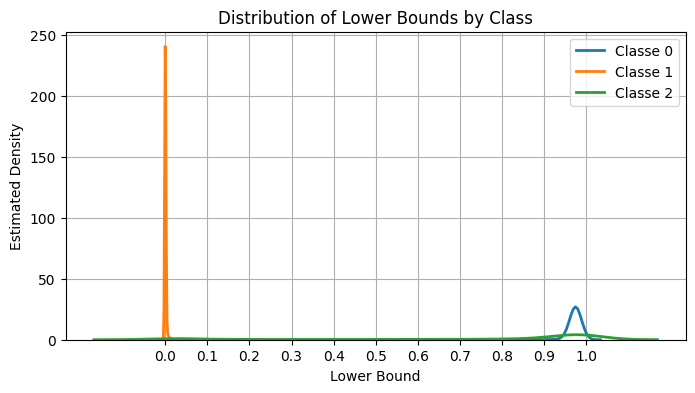

In [15]:
val_lower_bound = ImpreciseProbsframe.obtain_lower_bound(val_likelihoods)
test_lower_bound = ImpreciseProbsframe.obtain_lower_bound(test_likelihoods)

ImpreciseProbsframe.plot_lower_bound_distribution(val_lower_bound, val_labels)

#### Quartiles and Thresholds

In [ ]:
optimized_quartiles = QuartileApproach.optimize_quartiles(val_lower_bound, val_labels, val_likelihoods, num_folds=3, quartile_range=[0.25, 0.5, 0.75], num_classes=3)
thresholds = QuartileApproach.thresholds_from_lower_percentile(val_lower_bound, val_labels, optimized_quartiles)
print("Thresholds for each class:", [f"{t:.4f}" for t in thresholds])

Thresholds for each class: ['0.9769', '0.0000', '0.6142']


#### CRF

In [28]:
crf_model = CRFApproach(labels=val_labels, probs=val_likelihoods, num_classes=3)
crf_model.fit(n_trials=20)

[I 2025-07-11 17:52:23,109] A new study created in memory with name: no-name-2d7ba87c-bddf-4e87-b752-f5a6e4b300e4
[I 2025-07-11 17:52:32,282] Trial 0 finished with value: 0.3725173004028409 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 2.714074650953416}. Best is trial 0 with value: 0.3725173004028409.
[I 2025-07-11 17:52:41,601] Trial 1 finished with value: 0.3716463500445074 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 2.2855800804100506}. Best is trial 1 with value: 0.3716463500445074.
[I 2025-07-11 17:52:50,953] Trial 2 finished with value: 0.3712962731804583 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 1.0293240294119812}. Best is trial 2 with value: 0.3712962731804583.
[I 2025-07-11 17:53:01,626] Trial 3 finished with value: 0.3714090723705208 and parameters: {'sxy_gaussian': 1, 'compat_gaussian': 3.8541165985549943}. Best is trial 2 with value: 0.3712962731804583.
[I 2025-07-11 17:53:12,268] Trial 4 finished with value: 0.3714153832610645 and paramet

#### Imprecise Probability

In [29]:
confident_preds, confident_values, confident_mask = ImpreciseProbsframe.obtain_confident_values(test_lower_bound, thresholds)
final_probs_crf, pred_crf_filled = crf_model.inference(test_likelihoods, confident_mask, confident_values)

#### Print Metrics and compare

In [30]:
Metrics.print_metrics(test_likelihoods, test_labels, thresholds, name="Baseline Metrics")
Metrics.print_metrics(final_probs_crf, test_labels, thresholds, name="Imprecise Probability with CRF Approach Metrics")
Metrics.compute_metrics_certain_pixels(confident_values, test_labels, confident_mask)


=== Baseline Metrics ===
Average Precision per class: ['0.9908', '0.0808', '0.7450']
Mean Average Precision (mAP): 0.6055
Expected Calibration Error (ECE): 0.0053
Coverage (proportion of certain pixels): 1.0000

=== Imprecise Probability with CRF Approach Metrics ===
Average Precision per class: ['0.9856', '0.0808', '0.7506']
Mean Average Precision (mAP): 0.6056
Expected Calibration Error (ECE): 0.0154
Coverage (proportion of certain pixels): 1.0000

=== Imprecise Probability Approach Metrics for Certain Pixels ===
Average Precision per class: ['0.9742', '0.1476', '0.7922']
Mean Average Precision (mAP): 0.6380
Expected Calibration Error (ECE): 0.0158
Coverage (proportion of certain pixels): 0.3878
